In [1]:
!pip install -q tf-nightly
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 521.9MB 35kB/s 
     |████████████████████████████████| 460kB 46.1MB/s 
     |████████████████████████████████| 3.0MB 49.8MB/s 


In [2]:
exampledataset, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
trainexamples, valexamples = exampledataset['train'], exampledataset['validation']

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteIW9S5D/ted_hrlr_translate-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteIW9S5D/ted_hrlr_translate-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteIW9S5D/ted_hrlr_translate-test.tfrecord


Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [0]:
englishtoken = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in trainexamples), targetvocabsize=2**13)

portuguesetokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in trainexamples), targetvocabsize=2**13)

In [4]:
samplestring = 'Transformer is awesome.'

tokenizedstring = englishtoken.encode(samplestring)
print ('Tokenized string is {}'.format(tokenizedstring))

originalstring = englishtoken.decode(tokenizedstring)
print ('The original string: {}'.format(originalstring))

assert originalstring == samplestring

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


In [5]:
for ts in tokenizedstring:
  print ('{} ----> {}'.format(ts, englishtoken.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [0]:
def encode(langone, lang2):
  langone = [portuguesetokenizer.vocab_size] + portuguesetokenizer.encode(
      langone.numpy()) + [portuguesetokenizer.vocab_size+1]

  lang2 = [englishtoken.vocab_size] + englishtoken.encode(
      lang2.numpy()) + [englishtoken.vocab_size+1]
  
  return langone, lang2

In [0]:
def tfencode(pt, en):
  portresult, engresult = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  portresult.set_shape([None])
  engresult.set_shape([None])

  return portresult, engresult

In [0]:
MAX_LENGTH = 40

In [0]:
def filtermaxlength(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [0]:
trainpreprocessed = (
    trainexamples
    .map(tfencode) 
    .filter(filtermaxlength)
    .cache()
    .shuffle(BUFFER_SIZE))

valpreprocessed = (
    valexamples
    .map(tfencode)
    .filter(filtermaxlength))        

In [0]:
traindataset = (trainpreprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))


valdataset = (valpreprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [0]:
traindataset = (trainpreprocessed
                 .padded_batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE))


valdataset = (valpreprocessed
               .padded_batch(BATCH_SIZE))

In [14]:
portbatch, engbatch = next(iter(valdataset))
portbatch, engbatch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

In [0]:
def getangles(pos, i, d_model):
  anglerates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * anglerates

In [0]:
def positionalencoding(position, d_model):
  anglerads = getangles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  anglerads[:, 0::2] = np.sin(anglerads[:, 0::2])
  anglerads[:, 1::2] = np.cos(anglerads[:, 1::2])
    
  pos_encoding = anglerads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


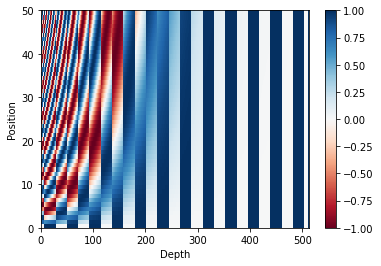

In [17]:
pos_encoding = positionalencoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [0]:
def createpaddingmask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  return seq[:, tf.newaxis, tf.newaxis, :]  

In [19]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
createpaddingmask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [0]:
def createlookaheadmask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask 

In [21]:
x = tf.random.uniform((1, 3))
temp = createlookaheadmask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [0]:
def scaleddotproductattention(q, k, v, mask):

  matmul_qk = tf.matmul(q, k, transpose_b=True)  
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaledattentionlogits = matmul_qk / tf.math.sqrt(dk)

  if mask is not None:
    scaledattentionlogits += (mask * -1e9)  

  attention_weights = tf.nn.softmax(scaledattentionlogits, axis=-1)  

  output = tf.matmul(attention_weights, v)  

  return output, attention_weights

In [0]:
def printout(q, k, v):
  temp_out, temp_attn = scaleddotproductattention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [24]:
np.set_printoptions(suppress=True)

tempk = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

tempv = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

tempq = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
printout(tempq, tempk, tempv)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [25]:
tempq = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
printout(tempq, tempk, tempv)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [26]:
tempq = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
printout(tempq, tempk, tempv)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [27]:
tempq = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
printout(tempq, tempk, tempv)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)   
    k = self.wk(k)   
    v = self.wv(v)   
    
    q = self.split_heads(q, batch_size)  
    k = self.split_heads(k, batch_size)  
    v = self.split_heads(v, batch_size)  
    scaled_attention, attention_weights = scaleddotproductattention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  
    output = self.dense(concat_attention) 
        
    return output, attention_weights

In [29]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512)) 
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [0]:
def pointwisefeedforwardnetwork(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  
      tf.keras.layers.Dense(d_model)   
  ])

In [31]:
sample_ffn = pointwisefeedforwardnetwork(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = pointwisefeedforwardnetwork(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)   
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)   
    
    ffn_output = self.ffn(out1)   
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)   
    
    return out2

In [33]:
sampleencoderlayer = EncoderLayer(512, 8, 2048)

sampleencoderlayeroutput = sampleencoderlayer(
    tf.random.uniform((64, 43, 512)), False, None)

sampleencoderlayeroutput.shape   

TensorShape([64, 43, 512])

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = pointwisefeedforwardnetwork(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           lookaheadmask, padding_mask):

    attn1, attn_weights_block1 = self.mha1(x, x, x, lookaheadmask)   
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)   
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)   
    
    ffn_output = self.ffn(out2)   
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)   
    
    return out3, attn_weights_block1, attn_weights_block2

In [35]:
sampledecoderlayer = DecoderLayer(512, 8, 2048)

sampledecoderlayeroutput, _, _ = sampledecoderlayer(
    tf.random.uniform((64, 50, 512)), sampleencoderlayeroutput, 
    False, None, None)

sampledecoderlayeroutput.shape   

TensorShape([64, 50, 512])

In [0]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, inputvocabsize,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(inputvocabsize, d_model)
    self.pos_encoding = positionalencoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    x = self.embedding(x)   
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x   

In [37]:
sampleencoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, inputvocabsize=8500,
                         maximum_position_encoding=10000)
tempinput = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sampleencoderoutput = sampleencoder(tempinput, training=False, mask=None)

print (sampleencoderoutput.shape)  

(64, 62, 512)


In [0]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, targetvocabsize,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(targetvocabsize, d_model)
    self.pos_encoding = positionalencoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           lookaheadmask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)   
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             lookaheadmask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    return x, attention_weights

In [39]:
sampledecoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sampledecoder(tempinput, 
                              enc_output=sampleencoderoutput, 
                              training=False,
                              lookaheadmask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [0]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               targetvocabsize, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           targetvocabsize, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(targetvocabsize)
    
  def call(self, inp, tar, training, encpaddingmask, 
           lookaheadmask, decpaddingmask):

    enc_output = self.encoder(inp, training, encpaddingmask)  
    
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, lookaheadmask, decpaddingmask)
    
    final_output = self.final_layer(dec_output) 
    
    return final_output, attention_weights

In [41]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, targetvocabsize=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               encpaddingmask=None, 
                               lookaheadmask=None,
                               decpaddingmask=None)

fn_out.shape  

TensorShape([64, 36, 8000])

In [0]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

inputvocabsize = portuguesetokenizer.vocab_size + 2
targetvocabsize = englishtoken.vocab_size + 2
dropout_rate = 0.1

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [0]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

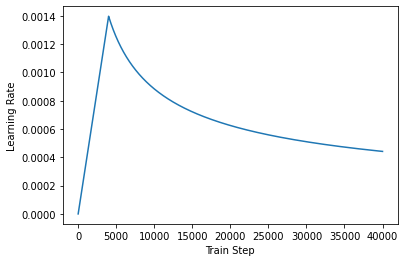

In [45]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [0]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          inputvocabsize, targetvocabsize, 
                          pe_input=inputvocabsize, 
                          pe_target=targetvocabsize,
                          rate=dropout_rate)

In [0]:
def createmasks(inp, tar):
  encpaddingmask = createpaddingmask(inp)
  
  decpaddingmask = createpaddingmask(inp)
  
  lookaheadmask = createlookaheadmask(tf.shape(tar)[1])
  dectargetpaddingmask = createpaddingmask(tar)
  combinedmask = tf.maximum(dectargetpaddingmask, lookaheadmask)
  
  return encpaddingmask, combinedmask, decpaddingmask

In [0]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [0]:
EPOCHS = 20

In [0]:


trainstepsignature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=trainstepsignature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  encpaddingmask, combinedmask, decpaddingmask = createmasks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 encpaddingmask, 
                                 combinedmask, 
                                 decpaddingmask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [54]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (inp, tar)) in enumerate(traindataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.0166 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.9634 Accuracy 0.0022
Epoch 1 Batch 100 Loss 8.8735 Accuracy 0.0094
Epoch 1 Batch 150 Loss 8.7708 Accuracy 0.0142
Epoch 1 Batch 200 Loss 8.6434 Accuracy 0.0174
Epoch 1 Batch 250 Loss 8.4896 Accuracy 0.0219
Epoch 1 Batch 300 Loss 8.3134 Accuracy 0.0275
Epoch 1 Batch 350 Loss 8.1269 Accuracy 0.0325
Epoch 1 Batch 400 Loss 7.9466 Accuracy 0.0363
Epoch 1 Batch 450 Loss 7.7820 Accuracy 0.0392
Epoch 1 Batch 500 Loss 7.6348 Accuracy 0.0417
Epoch 1 Batch 550 Loss 7.5004 Accuracy 0.0446
Epoch 1 Batch 600 Loss 7.3753 Accuracy 0.0481
Epoch 1 Batch 650 Loss 7.2547 Accuracy 0.0512
Epoch 1 Batch 700 Loss 7.1410 Accuracy 0.0543
Epoch 1 Loss 7.1364 Accuracy 0.0544
Time taken for 1 epoch: 100.73725509643555 secs

Epoch 2 Batch 0 Loss 5.5626 Accuracy 0.1000
Epoch 2 Batch 50 Loss 5.5267 Accuracy 0.1014
Epoch 2 Batch 100 Loss 5.4692 Accuracy 0.1039
Epoch 2 Batch 150 Loss 5.4111 Accuracy 0.1061
Epoch 2 Batch 200 Loss 5.3557 Accuracy 0.1082
E

In [0]:
def evaluate(inp_sentence):
  start_token = [portuguesetokenizer.vocab_size]
  end_token = [portuguesetokenizer.vocab_size + 1]
  
  inp_sentence = start_token + portuguesetokenizer.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  decoder_input = [englishtoken.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combinedmask, decpaddingmask = createmasks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 encpaddingmask,
                                                 combinedmask,
                                                 decpaddingmask)
    
    predictions = predictions[: ,-1:, :]  

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    if predicted_id == englishtoken.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [0]:
def plotattentionweights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = portuguesetokenizer.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[portuguesetokenizer.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([englishtoken.decode([i]) for i in result 
                        if i < englishtoken.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [0]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = englishtoken.decode([i for i in result 
                                            if i < englishtoken.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plotattentionweights(attention_weights, sentence, result, plot)

In [58]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a problem that we have to solve our own time .
Real translation: this is a problem we have to solve .


In [59]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


In [60]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'll be very quickly to share with you some of the little magic stories that have happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .
